# Лабораторная работа 1: «Метод обратного распространения ошибки»


**Цель** — изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой).

# Загрузка и отображение данных

In [33]:
import zipfile

file_path = "/content/drive/MyDrive/Лабораторные/Машинное обучение/Магистратура/Datasets/MNIST.zip"

# Распаковка архива
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    input_path = '/content/mnist_data'
    zip_ref.extractall(input_path)

In [34]:
import numpy as np
import struct
from array import array
from os.path import join


class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

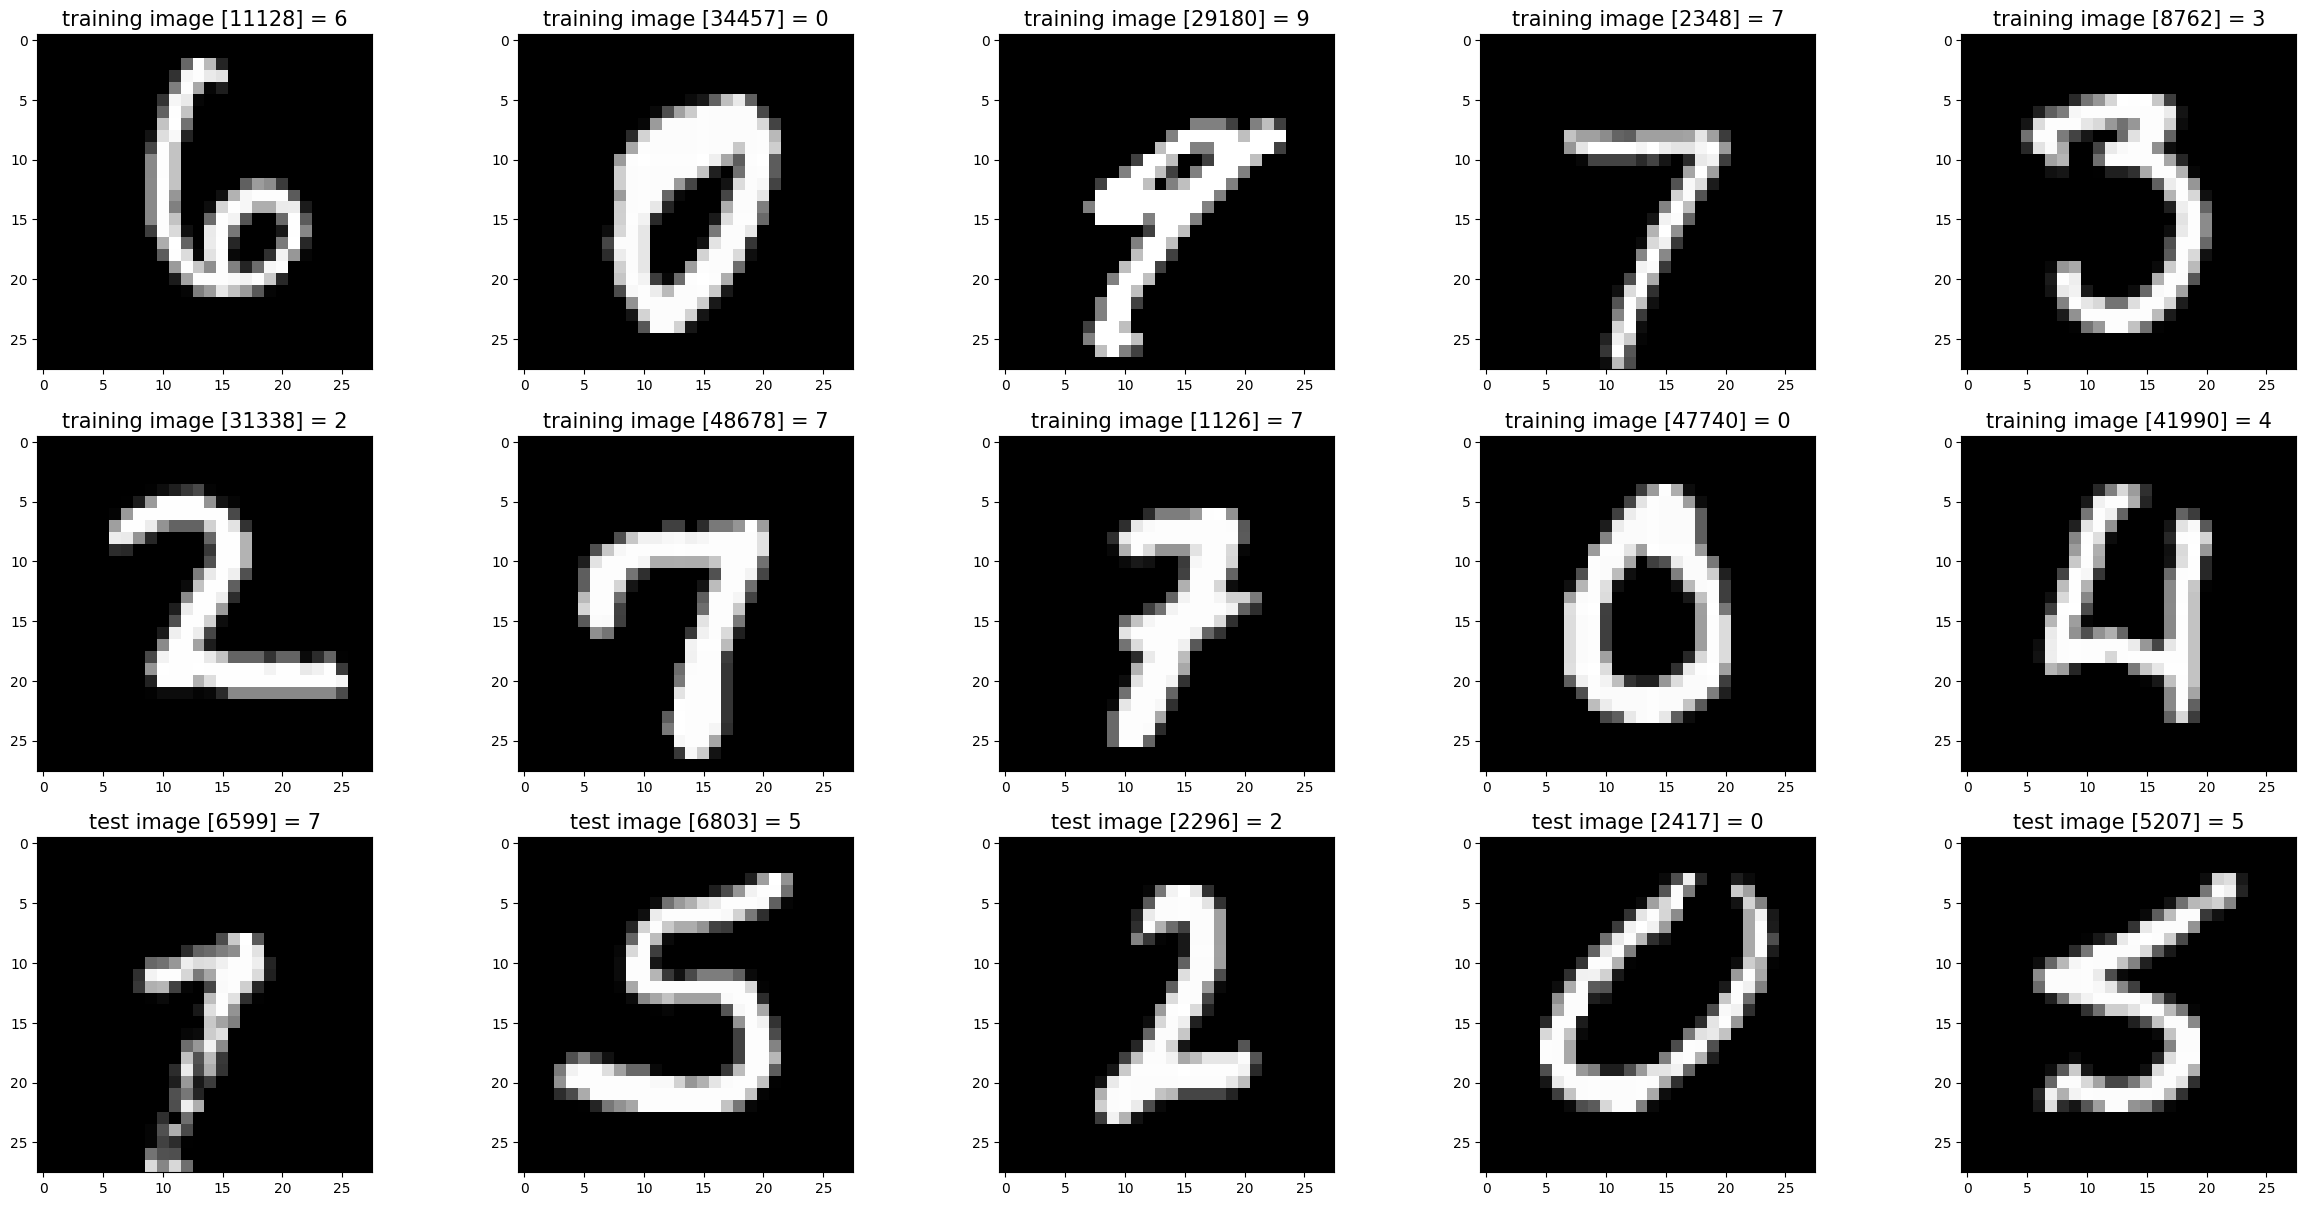

In [35]:
%matplotlib inline
import random
import matplotlib.pyplot as plt


training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

# Предобработка данных

In [36]:
# Преобразование массивов в нужный формат
x_train = np.array([np.array(sample, dtype='float32').flatten() for sample in x_train])
x_test = np.array([np.array(sample, dtype='float32').flatten() for sample in x_test])

# Нормализация
x_train = x_train / 255.0
x_test = x_test / 255.0

# Преобразование меток в one-hot вектор
new_y_train = np.zeros((len(y_train), 10), dtype='float32')
new_y_test = np.zeros((len(y_test), 10), dtype='float32')
for idx, label in enumerate(y_train):
  new_y_train[idx, label] = 1.0
for idx, label in enumerate(y_test):
  new_y_test[idx, label] = 1.0

y_train = new_y_train
y_test = new_y_test

# Определение класса нейросети и необходимых математических функций

In [37]:
import numpy as np

def ReLU(x):
  return np.maximum(x, 0.0)

def ReLU_derivative(x):
  # return np.where(x > 0, 1.0, 0.0)
  return (x > 0).astype(x.dtype)

def softmax(x):
  # Стабилизация softmax: вычитаем максимум для избежания переполнения
  x_stable = x - np.max(x, axis=1, keepdims=True)
  exps = np.exp(x_stable)
  probs = exps / np.sum(exps, axis=1, keepdims=True)
  return probs

def cross_entropy(probs, y_true):
  loss = -np.sum(y_true * np.log(probs + 1e-8))
  return loss

def softmax_cross_entropy(x, y_true):
  probs = softmax(x)
  loss = cross_entropy(probs, y_true)
  return probs, loss

def softmax_cross_entropy_derivative(probs, y_true):
  return probs - y_true

class TwoLayersFCNN:
  def __init__(self, input_dim, hidden_dim, output_dim):
    # Используем инициализацию "He" для ReLU
    self.weights_l1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
    self.bias_l1 = np.zeros(hidden_dim)
    self.weights_l2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
    self.bias_l2 = np.zeros(output_dim)

    self.model_cache = {
        "linear_output_l1": None,
        "activation_l1": None,
        "derivative_l1": None,

        "linear_output_l2": None,
        "activation_l2": None,
        "loss": None,
        "derivative_l2": None,
    }

  def clear_cache(self):
    for key in self.model_cache:
      self.model_cache[key] = None

  def forward(self, x, training=False, y_true=None):
    self.model_cache["linear_output_l1"] = x @ self.weights_l1 + self.bias_l1
    self.model_cache["activation_l1"] = ReLU(self.model_cache["linear_output_l1"])
    if training and y_true is not None:
      self.model_cache["derivative_l1"] = ReLU_derivative(self.model_cache["linear_output_l1"])

    self.model_cache["linear_output_l2"] = self.model_cache["activation_l1"] @ self.weights_l2 + self.bias_l2
    if training and y_true is not None:
      self.model_cache["activation_l2"], self.model_cache["loss"]  = softmax_cross_entropy(self.model_cache["linear_output_l2"], y_true)
      self.model_cache["derivative_l2"] = softmax_cross_entropy_derivative(self.model_cache["activation_l2"], y_true)
    else:
      self.model_cache["activation_l2"] = softmax(self.model_cache["linear_output_l2"])
    output = self.model_cache["activation_l2"]

    if not (training and y_true is not None):
      self.clear_cache()
    return output

  def backward(self, x, y, learning_rate):
    loss = self.model_cache["loss"]
    batch_size = x.shape[0]

    # Вычисление градиентов для выходного слоя
    delta2 = self.model_cache["derivative_l2"]
    dL_dW2 = (self.model_cache["activation_l1"].T @ delta2) / batch_size
    dL_db2 = np.sum(delta2, axis=0) / batch_size

    # Вычисление градиентов для скрытого слоя
    dL_da1 = delta2 @ self.weights_l2.T
    delta1 = dL_da1 * self.model_cache["derivative_l1"]

    dL_dW1 = (x.T @ delta1) / batch_size
    dL_db1 = np.sum(delta1, axis=0) / batch_size

    # Обновление параметров
    self.weights_l2 -= learning_rate * dL_dW2
    self.bias_l2 -= learning_rate * dL_db2
    self.weights_l1 -= learning_rate * dL_dW1
    self.bias_l1 -= learning_rate * dL_db1

  def predict_digits(self, x):
    probs = self.forward(x)
    return np.argmax(probs, axis=1)

# Определение функции обучения модели

In [38]:
import time
import matplotlib.pyplot as plt

def get_accuracy(model, x, y):
  predictions = model.predict_digits(x)
  return np.mean(predictions == np.argmax(y, axis=1))

def train_model(model, x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate):
  train_loss_history = []
  train_accuracy_history = []
  test_accuracy_history = []

  n_train = x_train.shape[0]
  n_test = x_test.shape[0]

  for epoch in range(epochs):
      epoch_start_time = time.time()

      indices = np.random.permutation(n_train)
      x_train_shuffled = x_train[indices]
      y_train_shuffled = y_train[indices]

      total_loss = 0.0
      for i in range(0, n_train, batch_size):
          end_idx = min(i + batch_size, n_train)
          x_batch = x_train_shuffled[i:end_idx]
          y_batch = y_train_shuffled[i:end_idx]

          model.forward(x_batch, training=True, y_true=y_batch)
          model.backward(x_batch, y_batch, learning_rate)

          total_loss += model.model_cache["loss"]

      epoch_time = time.time() - epoch_start_time

      avg_loss = total_loss / (n_train / batch_size)
      train_accuracy = get_accuracy(model, x_train, y_train)
      test_accuracy = get_accuracy(model, x_test, y_test)

      train_loss_history.append(avg_loss)
      train_accuracy_history.append(train_accuracy)
      test_accuracy_history.append(test_accuracy)

      print(f"Эпоха {epoch+1}/{epochs} | "
            f"Loss: {avg_loss:.4f} | "
            f"Train Acc: {train_accuracy:.4f} | "
            f"Test Acc: {test_accuracy:.4f} | "
            f"Время: {epoch_time:.2f}с")
  return {
      'train_loss': train_loss_history,
      'train_accuracy': train_accuracy_history,
      'test_accuracy': test_accuracy_history
  }

# Функция для построения графиков

In [39]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  ax1.plot(history['train_loss'], label='Train Loss', color='red')
  ax1.set_xlabel('Эпоха')
  ax1.set_ylabel('Loss')
  ax1.set_title('Функция потерь во время обучения')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  ax2.plot(history['train_accuracy'], label='Train Accuracy', color='blue')
  ax2.plot(history['test_accuracy'], label='Test Accuracy', color='green')
  ax2.set_xlabel('Эпоха')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Точность во время обучения')
  ax2.legend()
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

# Запуск обучения модели с заданными параметрами и построение графиков

Эпоха 1/20 | Loss: 22.7629 | Train Acc: 0.9383 | Test Acc: 0.9384 | Время: 5.70с
Эпоха 2/20 | Loss: 12.0016 | Train Acc: 0.9570 | Test Acc: 0.9530 | Время: 6.15с
Эпоха 3/20 | Loss: 8.8809 | Train Acc: 0.9675 | Test Acc: 0.9626 | Время: 5.10с
Эпоха 4/20 | Loss: 7.0706 | Train Acc: 0.9749 | Test Acc: 0.9686 | Время: 6.66с
Эпоха 5/20 | Loss: 5.8581 | Train Acc: 0.9782 | Test Acc: 0.9712 | Время: 4.78с
Эпоха 6/20 | Loss: 5.0086 | Train Acc: 0.9820 | Test Acc: 0.9739 | Время: 7.67с
Эпоха 7/20 | Loss: 4.3648 | Train Acc: 0.9806 | Test Acc: 0.9717 | Время: 3.99с
Эпоха 8/20 | Loss: 3.8452 | Train Acc: 0.9862 | Test Acc: 0.9763 | Время: 5.32с
Эпоха 9/20 | Loss: 3.4077 | Train Acc: 0.9882 | Test Acc: 0.9774 | Время: 4.65с
Эпоха 10/20 | Loss: 3.0604 | Train Acc: 0.9888 | Test Acc: 0.9775 | Время: 4.18с
Эпоха 11/20 | Loss: 2.7500 | Train Acc: 0.9894 | Test Acc: 0.9770 | Время: 6.62с
Эпоха 12/20 | Loss: 2.4670 | Train Acc: 0.9913 | Test Acc: 0.9789 | Время: 4.12с
Эпоха 13/20 | Loss: 2.2440 | Train 

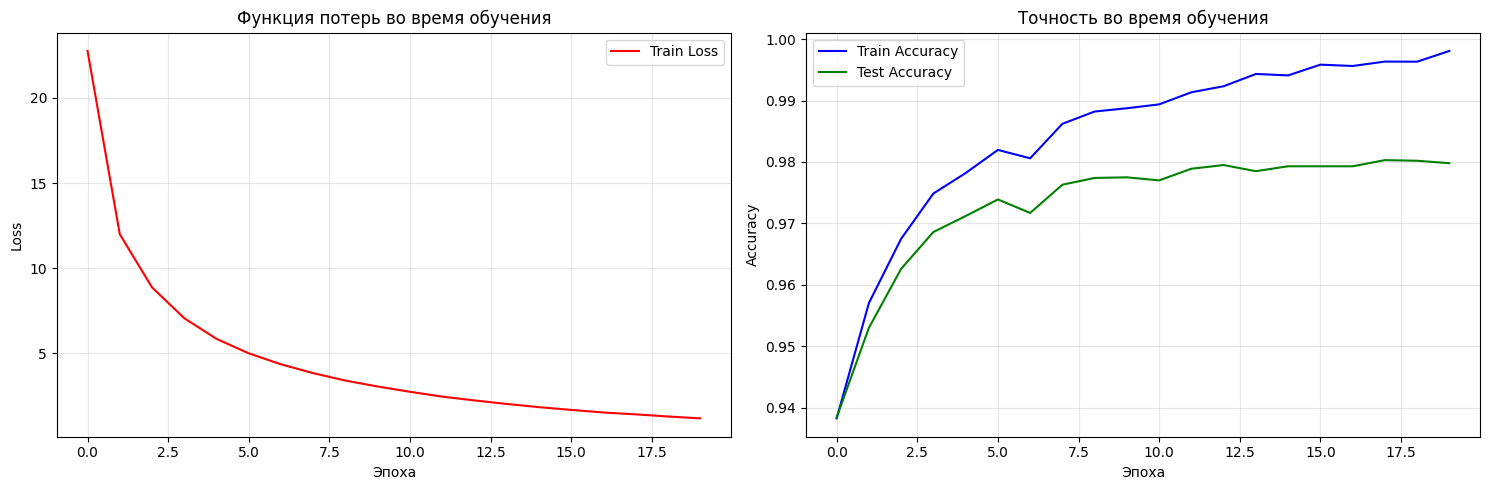

In [40]:
input_dim = 28*28
hidden_dim = 300
output_dim = 10
learning_rate = 0.1
batch_size = 64
epochs = 20

model = TwoLayersFCNN(input_dim, hidden_dim, output_dim)

history = train_model(
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate
)

final_train_acc = history["train_accuracy"][-1]
final_test_acc = history["test_accuracy"][-1]
print(f"Финальная точность: Train = {final_train_acc:.4f}, Test = {final_test_acc:.4f}")

plot_training_history(history)